[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/PTB-MR/mrpro/blob/main/examples/notebooks/cartesian_reconstruction.ipynb) [![Download notebook](https://img.shields.io/badge/Download-notebook-blue?logo=jupyter)](path:cartesian_reconstruction.ipynb)

In [1]:
import importlib

if not importlib.util.find_spec('mrpro'):
    %pip install mrpro[notebooks]

# Basics of MRpro and Cartesian reconstructions
Here, we are going to have a look at a few basics of MRpro and reconstruct data acquired with a Cartesian sampling
pattern.

## Overview
In this notebook, we are going to explore the `~mrpro.data.KData` object and the included header parameters.
We will then use a FFT-operator in order to reconstruct data acquired with a Cartesian sampling scheme.
We will also reconstruct data  acquired on a Cartesian grid but with partial echo and partial Fourier acceleration.
Finally, we will reconstruct a Cartesian scan with regular undersampling.

In [2]:
# Get the raw data from zenodo
import tempfile
from pathlib import Path

import zenodo_get

dataset = '14173489'

tmp = tempfile.TemporaryDirectory()  # RAII, automatically cleaned up
data_folder = Path(tmp.name)
zenodo_get.zenodo_get([dataset, '-r', 5, '-o', data_folder])  # r: retries

Title: 2D Cartesian MR raw data
Keywords: MR raw data
Publication date: 2024-11-16
DOI: 10.5281/zenodo.14173489
Total size: 140.9 MB

Link: https://zenodo.org/records/14173489/files/cart_t1.mrd   size: 50.7 MB



Checksum is correct. (45a3698b0c3b14de224172b7be46ac34)

Link: https://zenodo.org/records/14173489/files/cart_t1_msense_integrated.mrd   size: 43.9 MB



Checksum is correct. (4678ea99f7f9bcdd48127abef044dfe6)

Link: https://zenodo.org/records/14173489/files/cart_t1_partial_echo_partial_fourier.mrd   size: 46.2 MB



Checksum is correct. (6c069c1e804e25b3942bf10f6abde2db)
All files have been downloaded.


We have three different scans obtained from the same object with the same FOV and resolution, saved as ISMRMRD
raw data files (``*.mrd`` or ``*.h5``):

- ``cart_t1.mrd`` is a fully sampled Cartesian acquisition

- ``cart_t1_msense_integrated.mrd`` is accelerated using regular undersampling and self-calibrated SENSE

- ``cart_t1_partial_echo_partial_fourier.mrd`` is accelerated using partial echo and partial Fourier

## Read in raw data and explore header

To read in an ISMRMRD file, we can simply pass on the file name to a `~mrpro.data.KData` object.
Additionally, we need to provide information about the trajectory. In MRpro, this is done using trajectory
calculators. These are functions that calculate the trajectory based on the acquisition information and additional
parameters provided to the calculators (e.g. the angular step for a radial acquisition).

In this case, we have a Cartesian acquisition. This means that we only need to provide a Cartesian trajectory
calculator `~mrpro.data.traj_calculators.KTrajectoryCartesian` without any further parameters.

See <project:comparison_trajectory_calculators.ipynb> for more information about different ways to
define the trajectory.

In [3]:
import mrpro

kdata = mrpro.data.KData.from_file(
    data_folder / 'cart_t1.mrd',
    mrpro.data.traj_calculators.KTrajectoryCartesian(),
)

Now we can explore this data object.
Simply printing ``kdata`` gives us a basic overview of the `~mrpro.data.KData` object.

In [4]:
print(kdata)

KData on device "cpu" with (broadcasted) shape [1, 16, 1, 256, 512].
  data: Tensor<1, 16, 1, 256, 512>, |x| ∈ [9.88e-10, 0.00677], μ=1.03e-08+3.19e-08j, [-3.2594e-06-5.9281e-06j, -1.6065e-07+8.1374e-07j,  ...,  1.2878e-06-4.3239e-06j,  1.7020e-06+6.2282e-07j]
  traj: KTrajectory on device "cpu" with (broadcasted) shape [1, 1, 1, 256, 512].
     kz: Tensor<1, 1, 1, 1, 1>, constant 0
     ky: Tensor<1, 1, 1, 256, 1>, x ∈ [-128, 127], μ=-0.5, [-128., -127.,  ...,  126.,  127.]
     kx: Tensor<1, 1, 1, 1, 512>, x ∈ [-256, 255], μ=-0.5, [-256., -255.,  ...,  254.,  255.]
     grid_detection_tolerance: 0.001
     repeat_detection_tolerance: 0.001
  header:  KHeader on device "cpu" with (broadcasted) shape [1, 1, 1, 256, 1].
     recon_matrix: z=1, y=256, x=256
     encoding_matrix: z=1, y=256, x=512
     recon_fov: z=0.004, y=0.256, x=0.256
     encoding_fov: z=0.004, y=0.256, x=0.512
     acq_info: AcqInfo<1, 1, 1, 256, 1>
     trajectory: KTrajectoryCartesian()
     lamor_frequency_proton

We can also have a look at more specific header information like the 1H Lamor frequency

In [5]:
print('Lamor Frequency:', kdata.header.lamor_frequency_proton)

Lamor Frequency: 123252558


## Reconstruction of fully sampled acquisition

For the reconstruction of a fully sampled Cartesian acquisition, we can either use a general
`~mrpro.operators.FourierOp` or manually set up a Fast Fourier Transform (FFT).
For demonstration purposes, we first show the manual approach.

```{note}
 Most of the time, you will use the `~mrpro.operators.FourierOp` operator, which automatically takes care
of choosing  whether to use a FFT or a non-uniform FFT (NUFFT) based on the trajectory.
It optionally can be created from a `~mrpro.data.KData` object without any further information.
```

Let's create an FFT-operator `~mrpro.operators.FastFourierOp` and apply it to our `~mrpro.data.KData` object.
Please note that all MRpro operator work on PyTorch tensors and not on the MRpro objects directly. Therefore, we have
to call the operator on kdata.data. One other important property of MRpro operators is that they always return a
tuple of PyTorch tensors, even if the output is only a single tensor. This is why we use the ``(img,)`` syntax below.

In [6]:
fft_op = mrpro.operators.FastFourierOp(dim=(-2, -1))
(img,) = fft_op.adjoint(kdata.data)

Let's have a look at the shape of the obtained tensor.

In [7]:
print('Shape:', img.shape)

Shape: torch.Size([1, 16, 1, 256, 512])


We can see that the second dimension, which is the coil dimension, is 16. This means we still have a coil resolved
dataset (i.e. one image for each coil element). We can use a simply root-sum-of-squares approach to combine them into
one. Later, we will do something a bit more sophisticated. We can also see that the x-dimension is 512. This is
because in MRI we commonly oversample the readout direction by a factor 2 leading to a FOV twice as large as we
actually need. We can either remove this oversampling along the readout direction or we can simply tell the
`~mrpro.operators.FastFourierOp` to crop the image by providing the correct output matrix size ``recon_matrix``.

In [8]:
# Create FFT-operator with correct output matrix size
fft_op = mrpro.operators.FastFourierOp(
    dim=(-2, -1),
    recon_matrix=kdata.header.recon_matrix,
    encoding_matrix=kdata.header.encoding_matrix,
)

(img,) = fft_op.adjoint(kdata.data)
print('Shape:', img.shape)

Shape: torch.Size([1, 16, 1, 256, 256])


Now, we have an image which is 256 x 256 voxel as we would expect. Let's combine the data from the different receiver
coils using root-sum-of-squares and then display the image. Note that we usually index from behind in MRpro
(i.e. -1 for the last, -4 for the fourth last (coil) dimension) to allow for more than one 'other' dimension.

In [9]:
import matplotlib.pyplot as plt
import torch


def show_images(*images: torch.Tensor, titles: list[str] | None = None) -> None:
    """Plot images."""
    n_images = len(images)
    _, axes = plt.subplots(1, n_images, squeeze=False, figsize=(n_images * 3, 3))
    for i in range(n_images):
        axes[0][i].imshow(images[i], cmap='gray')
        axes[0][i].axis('off')
        if titles:
            axes[0][i].set_title(titles[i])
    plt.show()

/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:684: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x = np.array(x, subok=True, copy=copy)


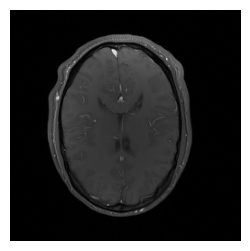

In [10]:
# Combine data from different coils and show magnitude image
magnitude_fully_sampled = img.abs().square().sum(dim=-4).sqrt().squeeze()
show_images(magnitude_fully_sampled)

Great! That was very easy! Let's try to reconstruct the next dataset.

## Reconstruction of acquisition with partial echo and partial Fourier

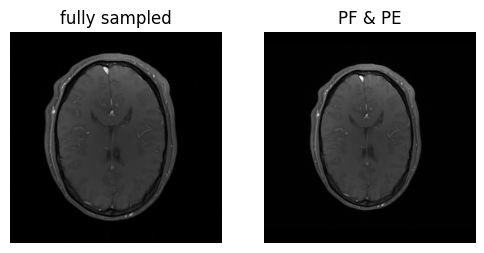

In [11]:
# Read in the data
kdata_pe_pf = mrpro.data.KData.from_file(
    data_folder / 'cart_t1_partial_echo_partial_fourier.mrd',
    mrpro.data.traj_calculators.KTrajectoryCartesian(),
)

# Create FFT-operator with correct output matrix size
fft_op = mrpro.operators.FastFourierOp(
    dim=(-2, -1),
    recon_matrix=kdata.header.recon_matrix,
    encoding_matrix=kdata.header.encoding_matrix,
)

# Reconstruct coil resolved image(s)
(img_pe_pf,) = fft_op.adjoint(kdata_pe_pf.data)

# Combine data from different coils using root-sum-of-squares
magnitude_pe_pf = img_pe_pf.abs().square().sum(dim=-4).sqrt().squeeze()

# Plot both images
show_images(magnitude_fully_sampled, magnitude_pe_pf, titles=['fully sampled', 'PF & PE'])

Well, we got an image, but when we compare it to the previous result, it seems like the head has shrunk.
Since that's extremely unlikely, there's probably a mistake in our reconstruction.

Let's step back and check out the trajectories for both scans.

In [12]:
print(kdata.traj)

KTrajectory on device "cpu" with (broadcasted) shape [1, 1, 1, 256, 512].
  kz: Tensor<1, 1, 1, 1, 1>, constant 0
  ky: Tensor<1, 1, 1, 256, 1>, x ∈ [-128, 127], μ=-0.5, [-128., -127.,  ...,  126.,  127.]
  kx: Tensor<1, 1, 1, 1, 512>, x ∈ [-256, 255], μ=-0.5, [-256., -255.,  ...,  254.,  255.]
  grid_detection_tolerance: 0.001
  repeat_detection_tolerance: 0.001


We see that the trajectory has ``kz``, ``ky``, and ``kx`` components. ``kx`` and ``ky`` only vary along one dimension.
```{note}
This is because MRpro saves meta data such as trajectories in an efficient way, where dimensions in which the data
does not change are often collapsed. The original shape can be obtained by
[broadcasting](https://numpy.org/doc/stable/user/basics.broadcasting.html).
```
To get the full trajectory as a tensor, we can also just call `~mrpro.data.KTrajectory.as_tensor()`:

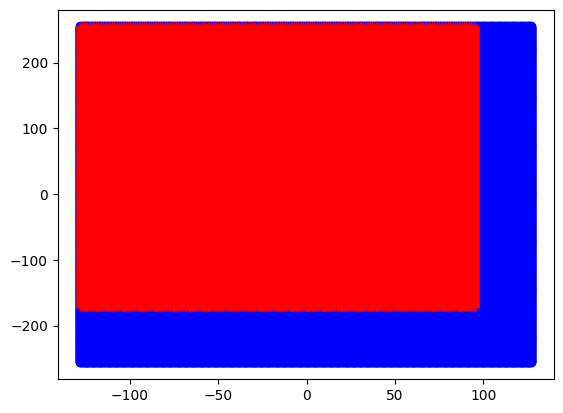

In [13]:
# Plot the fully sampled trajectory (in blue)
full_kz, full_ky, full_kx = kdata.traj.as_tensor()
plt.plot(full_ky[0, 0].flatten(), full_kx[0, 0].flatten(), 'ob')

# Plot the partial echo and partial Fourier trajectory (in red)
full_kz, full_ky, full_kx = kdata_pe_pf.traj.as_tensor()
plt.plot(full_ky[0, 0].flatten(), full_kx[0, 0].flatten(), '+r')

plt.show()

We see that for the fully sampled acquisition, the k-space is covered symmetrically from -256 to 255 along the
readout direction and from -128 to 127 along the phase encoding direction. For the acquisition with partial Fourier
and partial echo acceleration, this is of course not the case and the k-space is asymmetrical.

Our FFT-operator does not know about this and simply assumes that the acquisition is symmetric and any difference
between encoding and recon matrix needs to be zero-padded symmetrically.

To take the asymmetric acquisition into account and sort the data correctly into a matrix where we can apply the
FFT-operator to, we have got the `~mrpro.operators.CartesianSamplingOp` in MRpro. This operator performs
sorting based on the k-space trajectory and the dimensions of the encoding k-space.

Let's try it out!

In [14]:
cart_sampling_op = mrpro.operators.CartesianSamplingOp(
    encoding_matrix=kdata_pe_pf.header.encoding_matrix, traj=kdata_pe_pf.traj
)

Now, we first apply the adjoint CartesianSamplingOp and then call the adjoint FFT-operator.

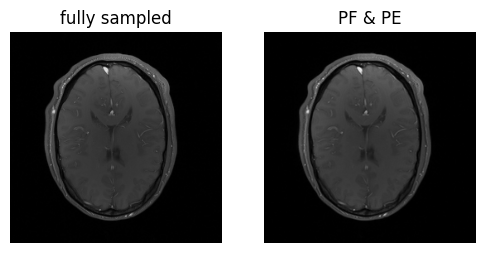

In [15]:
(img_pe_pf,) = fft_op.adjoint(cart_sampling_op.adjoint(kdata_pe_pf.data)[0])
magnitude_pe_pf = img_pe_pf.abs().square().sum(dim=-4).sqrt().squeeze()

show_images(magnitude_fully_sampled, magnitude_pe_pf, titles=['fully sampled', 'PF & PE'])

Voila! We've got the same brains, and they're the same size!

## More about operators
### The Fourier Operator
In MRpro, we have a smart `~mrpro.operators.FourierOp` operator, that automatically does the resorting and can
handle non-cartesian data as well. For cartesian data, it internally does exactly the two steps we just did manually.
The operator can be also be created from an existing `~mrpro.data.KData` object
This is the recommended way to transform k-space data.

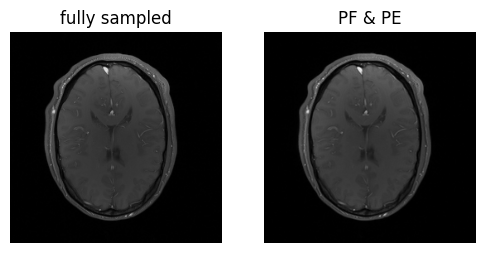

In [16]:

fourier_op = mrpro.operators.FourierOp.from_kdata(kdata_pe_pf)
# no need for and explicit CartesianSamplingOp anymore!
(img_pe_pf,) = fourier_op.adjoint(kdata_pe_pf.data)
magnitude_pe_pf = img_pe_pf.abs().square().sum(dim=-4).sqrt().squeeze()
show_images(magnitude_fully_sampled, magnitude_pe_pf, titles=['fully sampled', 'PF & PE'])

That was easy!
But wait a second — something still looks a bit off. In the bottom left corner, it seems like there's a "hole"
in the brain. That definitely shouldn't be there.

The issue is that we combined the data from the different coils using a root-sum-of-squares approach.
While it's simple, it's not the ideal method. Typically, coil sensitivity maps are calculated to combine the data
from different coils. In MRpro, you can do this by calculating coil sensitivity data and then creating a
`~mrpro.operators.SensitivityOp` to combine the data after image reconstruction.

### Sensitivity Operator
We have different options for calculating coil sensitivity maps from the image data of the various coils.
Here, we're going to use the Walsh method.

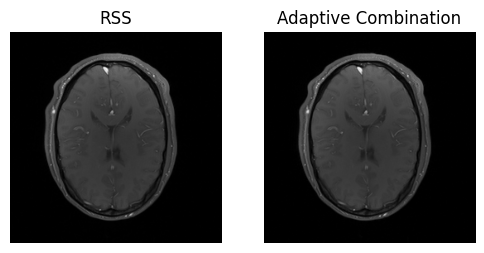

In [17]:
# Calculate coil sensitivity maps
(img_pe_pf,) = fft_op.adjoint(*cart_sampling_op.adjoint(kdata_pe_pf.data))

# This algorithms is designed to calculate coil sensitivity maps for each other dimension.
csm_data = mrpro.algorithms.csm.walsh(img_pe_pf[0, ...], smoothing_width=5)[None, ...]

# Create SensitivityOp
csm_op = mrpro.operators.SensitivityOp(csm_data)

# Reconstruct coil-combined image
(img_walsh_combined,) = csm_op.adjoint(*fourier_op.adjoint(kdata_pe_pf.data))
magnitude_walsh_combined = img_walsh_combined.abs().squeeze()
show_images(magnitude_pe_pf, magnitude_walsh_combined, titles=['RSS', 'Adaptive Combination'])

Tada! The "hole" is gone, and the image looks much better 🎉.

When we reconstructed the image, we called the adjoint method of several different operators one after the other. That
was a bit cumbersome. To make our life easier, MRpro allows to combine the operators first, get the adjoint
of the composite operator and then later call this adjoint composite operator.

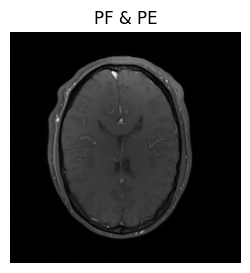

In [18]:
### Operator Composition
# Create composite operator
adjoint_operator = (fourier_op @ csm_op).H
(magnitude_pe_pf,) = adjoint_operator(kdata_pe_pf.data)
magnitude_pe_pf = magnitude_pe_pf.abs().squeeze()
show_images(magnitude_pe_pf, titles=['PF & PE'])

Although we now have got a nice looking image, it was still a bit cumbersome to create it. We had to define several
different operators and chain them together. Wouldn't it be nice if this could be done automatically?

That is why we also included some top-level reconstruction algorithms in MRpro. For this whole steps from above,
we can simply use a `~mrpro.algorithms.reconstruction.DirectReconstruction`.
Reconstruction algorithms can be instantiated from only the information in the `~mrpro.data.KData` object.

In contrast to operators, top-level reconstruction algorithms operate on the data objects of MRpro, i.e. the input is
a `~mrpro.data.KData` object and the output is an `~mrpro.data.IData` object containing
the reconstructed image data. To get its magnitude, we can call the `~mrpro.data.IData.rss` method.

In [19]:

# Create DirectReconstruction object from KData object
direct_recon_pe_pf = mrpro.algorithms.reconstruction.DirectReconstruction(kdata_pe_pf)

# Reconstruct image by calling the DirectReconstruction object
idat_pe_pf = direct_recon_pe_pf(kdata_pe_pf)

This is much simpler — everything happens in the background, so we don't have to worry about it.

## Reconstruction of undersampled data
Let's finally try it on the undersampled dataset.

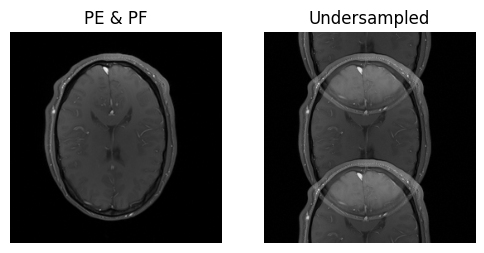

In [20]:
kdata_us = mrpro.data.KData.from_file(
    data_folder / 'cart_t1_msense_integrated.mrd',
    mrpro.data.traj_calculators.KTrajectoryCartesian(),
)
direct_recon_us = mrpro.algorithms.reconstruction.DirectReconstruction(kdata_us)
idat_us = direct_recon_us(kdata_us)

show_images(idat_pe_pf.rss().squeeze(), idat_us.rss().squeeze(), titles=['PE & PF', 'Undersampled'])

## Using Calibration Data
We used the same data for coil sensitivity calculation as for image reconstruction (*auto-calibration*).
Another approach is to acquire a few calibration lines in the center of k-space to create a low-resolution,
fully sampled image. In our example data from Siemens scanners, these lines are part of the dataset.
As they aren't meant to be used for image reconstruction, only for calibration, i.e., coil sensitivity calculation,
and are labeled in the data as such, they are ignored by the default `acquisition_filter_criterion` of
`~mrpro.data.KData.from_file`.
However, we can change the filter criterion to `is_coil_calibration_acquisition` to read in only these acquisitions.

```{note}
There are already some other filter criteria available, see `mrpro.data.acq_filters`. You can also implement your own
function returning whether to include an acquisition
```


In [21]:
kdata_calib_lines = mrpro.data.KData.from_file(
    data_folder / 'cart_t1_msense_integrated.mrd',
    mrpro.data.traj_calculators.KTrajectoryCartesian(),
    acquisition_filter_criterion=mrpro.data.acq_filters.is_coil_calibration_acquisition,
)

direct_recon_calib_lines = mrpro.algorithms.reconstruction.DirectReconstruction(kdata_calib_lines)
idat_calib_lines = direct_recon_calib_lines(kdata_calib_lines)

If we look at the reconstructed image, we see it is low resolution..

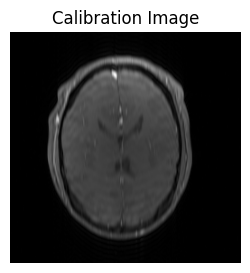

In [22]:
show_images(idat_calib_lines.rss().squeeze(), titles=['Calibration Image'])

..but it is good enough to calculate coil sensitivity maps:

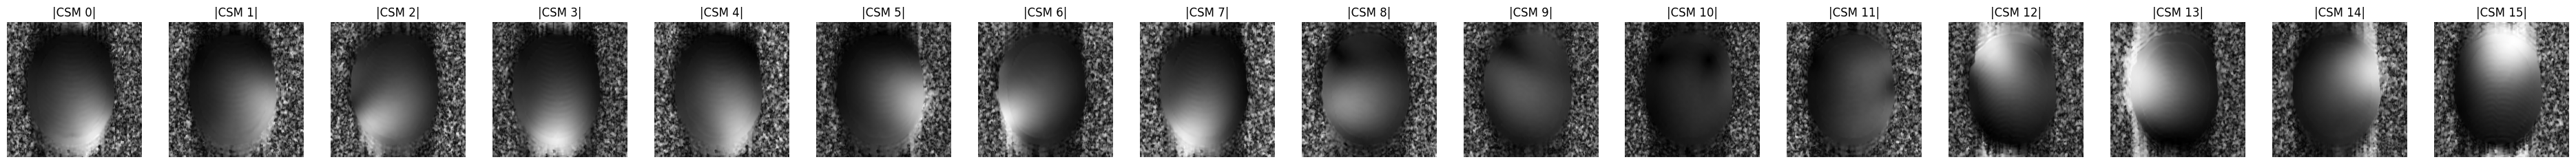

In [23]:
# The coil sensitivity maps
assert direct_recon_calib_lines.csm is not None
show_images(
    *direct_recon_calib_lines.csm.data[0].abs().squeeze(),
    titles=[f'|CSM {i}|' for i in range(direct_recon_calib_lines.csm.data.size(-4))],
)

### Reconstruction
We can now use these CSMs in a new `~mrpro.algorithms.reconstruction.DirectReconstruction`:

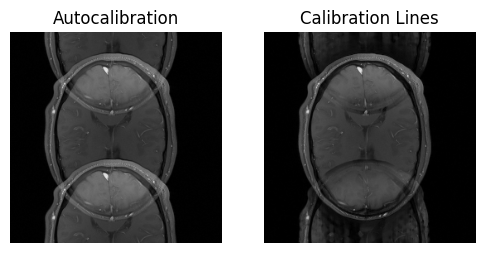

In [24]:
direct_recon_us_csm = mrpro.algorithms.reconstruction.DirectReconstruction(kdata_us, csm=direct_recon_calib_lines.csm)
idat_us_csm = direct_recon_us_csm(kdata_us)
show_images(idat_us.rss().squeeze(), idat_us_csm.rss().squeeze(), titles=['Autocalibration', 'Calibration Lines'])

As expected, we still see undersampling artifacts in the image. In order to get rid of them,
we try can a more sophisticated reconstruction method, such as the *iterative SENSE algorithm*.
As you might have guessed, these are also included in MRpro:
Instead of the `~mrpro.algorithms.reconstruction.DirectReconstruction`,
we can use `~mrpro.algorithms.reconstruction.IterativeSENSEReconstruction`:

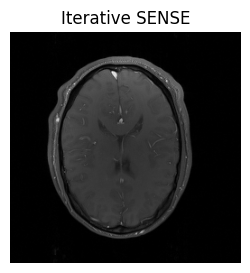

In [25]:
sense_recon_us = mrpro.algorithms.reconstruction.IterativeSENSEReconstruction(
    kdata_us,
    csm=direct_recon_calib_lines.csm,
    n_iterations=8,
)
idat_us_sense = sense_recon_us(kdata_us)
show_images(idat_us_sense.rss().squeeze(), titles=['Iterative SENSE'])

This looks better! More information about the iterative SENSE reconstruction and its implementation in MRpro
can be found in the examples <project:iterative_sense_reconstruction_radial2D.ipynb> and
<project:iterative_sense_reconstruction_with_regularization.ipynb>.